# IMDB로 센텐스피스 감성리뷰하기

In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.0 MB/s 


In [3]:
import sentencepiece as spm
import pandas as pd
import urllib.request
import csv

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7f8ad3e5b150>)

In [5]:
train_df = pd.read_csv('IMDb_Reviews.csv')

In [6]:
train_df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [7]:
print('리뷰 갯수 :', len(train_df))

리뷰 갯수 : 50000


In [8]:
with open('imdb_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_df['review']))

sentencepiece의 자세한 실행 옵션 : https://github.com/google/sentencepiece

```
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰
```
```
spm.SentencePieceTrainer.Train('--input=imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')
```

- input : 학습시킬 파일
- model_prefix : 만들어질 모델 이름
- vocab_size : 단어집합크기
- model_type : 사용할 모델 (unigram(default), bpe, char, word)
- pad_id, pad_piece : pad token id, 값
- unk_id, unk_piece : unknown token id, 값
- bos_id, bos_piece : begin of sentence token id,값
- eos_id, eos_piece : end of sequence token id, 값
- user_defined_symbols : 사용자 정의 토큰

In [9]:
corpus = 'imdb_review.txt' # 입력 corpus
prefix = 'imdb' # 저장할 단어장 이름
vocab_size = 5000
spm.SentencePieceTrainer.Train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999") # 문장 최대 길이

In [10]:
vocab_list = pd.read_csv('imdb.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.sample(10)

,0,1
3116,▁terror,-3113
4398,pective,-4395
56,ct,-53
1275,/10,-1272
1417,aughter,-1414
1824,iddle,-1821
1727,▁heard,-1724
1658,ished,-1655
3220,▁contri,-3217
2204,ublic,-2201


In [11]:
len(vocab_list)

5000

In [12]:
sp = spm.SentencePieceProcessor()
vocab_file = "imdb.model"
sp.load(vocab_file)

True

In [13]:
lines = [
         "I didn't at all think of it this way.",
         "I have waited a long time for someone to film"
]
for line in lines:
    print(line)
    print(sp.encode_as_pieces(line)) # 문장을 입력하면 서브워드 시퀀스로 변환
    print(sp.encode_as_ids(line)) # 문장을 입력하면 정수 시퀀스로 변환
    print()

I didn't at all think of it this way.
['▁I', '▁didn', "'", 't', '▁at', '▁all', '▁think', '▁of', '▁it', '▁this', '▁way', '.']
[41, 623, 4950, 4926, 138, 169, 379, 30, 58, 73, 414, 4945]

I have waited a long time for someone to film
['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[41, 141, 1365, 1120, 4, 666, 285, 92, 1078, 33, 91]



In [14]:
sp.GetPieceSize() # 단어집합의 크기

5000

In [15]:
sp.IdToPiece(120) # 정수로부터 매핑되는 서브워드 변환

'▁not'

In [16]:
sp.PieceToId('▁not') # 서브워드로부터 매핑되는 정수로 변환

120

In [17]:
sp.DecodeIds([41, 141, 1365, 1120, 4, 666, 285, 92, 1078, 33, 91])
# 정수 시퀀스를 sp.DecodeIds의 정수 시퀀스에 입력하기

'I have waited a long time for someone to film'

In [18]:
sp.DecodePieces(['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film'])
# 서브워드 시퀀스로부터 문장으로 변환

'I have waited a long time for someone to film'

In [19]:
print(sp.encode('I have waited a long time for someone to film', out_type=str))
# subword 시퀀스 
print(sp.encode('I have waited a long time for someone to film', out_type=int))
# 정수 시퀀스

['▁I', '▁have', '▁wa', 'ited', '▁a', '▁long', '▁time', '▁for', '▁someone', '▁to', '▁film']
[41, 141, 1365, 1120, 4, 666, 285, 92, 1078, 33, 91]


# 네이버 영화리뷰로 센텐스피스 적용하기

In [20]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv

In [21]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f8ad4dd1b90>)

In [22]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [23]:
print('리뷰 갯수 :', len(naver_df))

리뷰 갯수 : 200000


In [24]:
print(naver_df.isnull().values.any())

True


In [25]:
# Null값이 존재하는 행 제거
naver_df = naver_df.dropna(how='any')
# Null값이 존재하는지 확인하기
print(naver_df.isnull().values.any())

False


In [26]:
# 리뷰 갯수 출력하기
print('리뷰 갯수 :',len(naver_df))

리뷰 갯수 : 199992


In [27]:
with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(naver_df['document']))

In [28]:
spm.SentencePieceTrainer.Train('--input=naver_review.txt --model_prefix=naver --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

In [29]:
# vocab을 불러오기 pd.read_csv
vocab_list = pd.read_csv('naver.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list.head(10)

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [30]:
sp = spm.SentencePieceProcessor()
vocab_file = "naver.model"
sp.load(vocab_file)

True

In [31]:
lines = [
         "뭐 이딴 것도 영화냐.",
         "진짜 최고의 영화입니다ㅋㅋ",
]
for line in lines:
    print(line)
    print(sp.encode_as_pieces(line))
    print(sp.encode_as_ids(line))
    print()

뭐 이딴 것도 영화냐.
['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']
[132, 966, 1296, 2590, 3276]

진짜 최고의 영화입니다ㅋㅋ
['▁진짜', '▁최고의', '▁영화입니다', 'ᄏᄏ']
[54, 200, 821, 12]



In [32]:
sp.GetPieceSize()

5000

In [33]:
sp.IdToPiece(4)

'영화'

In [34]:
sp.PieceToId('영화')

4

In [35]:
sp.DecodeIds([132, 966, 1296, 2590, 3276])

'뭐 이딴 것도 영화냐.'

In [36]:
sp.DecodePieces(['▁뭐', '▁이딴', '▁것도', '▁영화냐', '.']) #서브워드 시퀀스 입력

'뭐 이딴 것도 영화냐.'

In [37]:
print(sp.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=str))
print(sp.encode('진짜 최고의 영화입니다 ㅋㅋ', out_type=int))

['▁진짜', '▁최고의', '▁영화입니다', '▁ᄏᄏ']
[54, 200, 821, 85]


# 네이버 영화 리뷰 감성분석

### 1. 데이터 준비와 확인

In [38]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 77.9 MB/s 


In [39]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f8a59ebe610>)

In [41]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [42]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [43]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 1.61 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-20 01:56:12--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=e39AH0

### 2. 데이터로더 구성

In [44]:
from konlpy.tag import Mecab

def tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence)
        curr_data = [word for word in curr_data if not word in stopwords]
        result.append(curr_data)
    return result

In [45]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [46]:
def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # NaN 결측지 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 토큰화 및 불용어 제거
    x_train = tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

In [47]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [48]:
print(x_train[10])

[2, 4, 39, 229, 6, 535]


In [49]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [50]:
#문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것을 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])
    # [1:]를 통해 <BOS>제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [51]:
get_decoded_sentence(x_train[10], index_to_word)

'. 진짜 짱 다 ♥'

### 3. 모델 구성을 위한 데이터 분석 및 가공

In [52]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(x_train) + list(x_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 예를 들어 최대 길이를 (평균 + 2* 표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2* np.std(num_tokens)

maxlen = int(max_tokens)
print('pad sequences maxlen :', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens <max_tokens) / len(num_tokens)))

문장길이 평균 : 15.96940191154864
문장길이 최대 : 116
문장길이 표준편차 : 12.843571191092
pad sequences maxlen : 41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


In [53]:
# 패딩 추가
x_train = keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)

In [54]:
print(x_train.shape)
print(x_test.shape)

(146182, 41)
(49157, 41)


### 4. 모델 구성 및 validation 구성

In [55]:
vocab_size = 10000 
word_vector_dim = 200 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련

In [56]:
# validation set 분리 (임의로 50000건 설정)
x_val = x_train[:50000]
y_val = y_train[:50000]

partial_x_train = x_train[50000:]
partial_y_train = y_train[50000:]

In [57]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 100

history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data = (x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 7s 11ms/step - loss: 0.4658 - accuracy: 0.7970 - val_loss: 0.3608 - val_accuracy: 0.8444
Epoch 2/100
188/188 [==============================] - 2s 8ms/step - loss: 0.3270 - accuracy: 0.8625 - val_loss: 0.3425 - val_accuracy: 0.8524
Epoch 3/100
188/188 [==============================] - 2s 9ms/step - loss: 0.2919 - accuracy: 0.8791 - val_loss: 0.3407 - val_accuracy: 0.8542
Epoch 4/100
188/188 [==============================] - 2s 8ms/step - loss: 0.2634 - accuracy: 0.8917 - val_loss: 0.3463 - val_accuracy: 0.8551
Epoch 5/100
188/188 [==============================] - 2s 8ms/step - loss: 0.2362 - accuracy: 0.9042 - val_loss: 0.3558 - val_accuracy: 0.8534
Epoch 6/100
188/188 [==============================] - 2s 8ms/step - loss: 0.2128 - accuracy: 0.9140 - val_loss: 0.3735 - val_accuracy: 0.8512
Epoch 7/100
188/188 [==============================] - 2s 8ms/step - loss: 0.1905 - accuracy: 0.9246 - val_loss: 0.3942 - val_accuracy: 0.849

In [58]:
results = model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 1.7247 - accuracy: 0.8149 - 4s/epoch - 2ms/step
[1.724655032157898, 0.814899206161499]


In [59]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [60]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

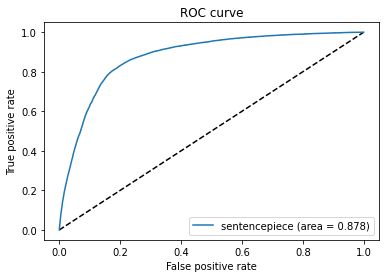

In [62]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='sentencepiece (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

### 6. loss, accuracy 그래프 시각화

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


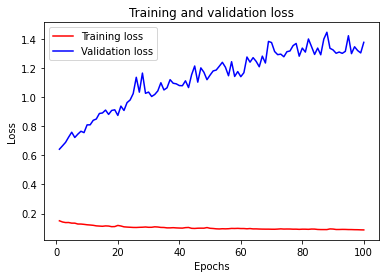

In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r-', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

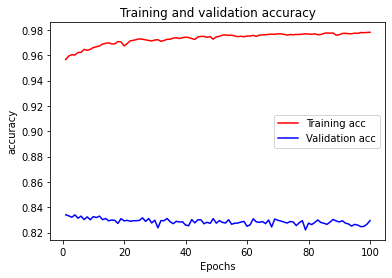

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 네이버 영화 리뷰 감성 분류에 SentencePiece적용해 보기

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

```
vocab_size = 8000
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)
)
```

```
1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?
```

```
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word
```

```
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)
```